# Introduction

Fraud detection is critical for audit companies and financial institutions to ensure the integrity and trustworthiness of financial statements and transactions. Fraudulent activities can result in significant financial losses and reputational damage for businesses and investors. Therefore, developing accurate and effective fraud detection models is crucial to identify potential fraud cases and risks.
The main question we will try to answer in our project is: How can we build a classification model that accurately identifies fraudulent companies?
The dataset includes financial data, transactional data, company information, and external data. By leveraging this dataset, we can develop a classification model that learns patterns and characteristics associated with fraudulent companies, enabling us to accurately predict and identify potential fraud cases in the future.


# Preliminary EDA

### Import Libraries

In [1]:
library(tidyverse)
library(tidymodels)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

### Downloading & Reading File

In [2]:
file_url = "https://archive.ics.uci.edu/static/public/475/audit+data.zip"
zip = download.file(file_url, "audit.zip")
unzipped = unzip("audit.zip")

audit_data = read_csv("audit_data/audit_risk.csv")
head(audit_data)
colnames(audit_data)

New names:
• `Score_B` -> `Score_B...7`
• `Score_B` -> `Score_B...11`
Rows: 776 Columns: 27
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): LOCATION_ID
dbl (26): Sector_score, PARA_A, Score_A, Risk_A, PARA_B, Score_B...7, Risk_B...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Sector_score,LOCATION_ID,PARA_A,Score_A,Risk_A,PARA_B,Score_B...7,Risk_B,TOTAL,numbers,⋯,RiSk_E,History,Prob,Risk_F,Score,Inherent_Risk,CONTROL_RISK,Detection_Risk,Audit_Risk,Risk
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3.89,23,4.18,0.6,2.508,2.50,0.2,0.500,6.68,5,⋯,0.4,0,0.2,0,2.4,8.574,0.4,0.5,1.7148,1
3.89,6,0.00,0.2,0.000,4.83,0.2,0.966,4.83,5,⋯,0.4,0,0.2,0,2.0,2.554,0.4,0.5,0.5108,0
3.89,6,0.51,0.2,0.102,0.23,0.2,0.046,0.74,5,⋯,0.4,0,0.2,0,2.0,1.548,0.4,0.5,0.3096,0
3.89,6,0.00,0.2,0.000,10.80,0.6,6.480,10.80,6,⋯,0.4,0,0.2,0,4.4,17.530,0.4,0.5,3.5060,1
3.89,6,0.00,0.2,0.000,0.08,0.2,0.016,0.08,5,⋯,0.4,0,0.2,0,2.0,1.416,0.4,0.5,0.2832,0
3.89,6,0.00,0.2,0.000,0.83,0.2,0.166,0.83,5,⋯,0.4,0,0.2,0,2.0,2.156,0.4,0.5,0.4312,0


[1] "Sector_score"   "LOCATION_ID"    "PARA_A"         "Score_A"       
 [5] "Risk_A"         "PARA_B"         "Score_B...7"    "Risk_B"        
 [9] "TOTAL"          "numbers"        "Score_B...11"   "Risk_C"        
[13] "Money_Value"    "Score_MV"       "Risk_D"         "District_Loss" 
[17] "PROB"           "RiSk_E"         "History"        "Prob"          
[21] "Risk_F"         "Score"          "Inherent_Risk"  "CONTROL_RISK"  
[25] "Detection_Risk" "Audit_Risk"     "Risk"

### Wrangling & Cleaning

Looking at the data, it seems like it is tidy already and column types are well defined. The column names are inconsistent with case so we'll standardize it by uppercasing everything. The risk column is going to be our target class, therefore we will also change the type from dbl to factor.

In [3]:
colnames(audit_data) = toupper(colnames(audit_data))

Before changing the risk column to factor and examining the dataset, let's investigate the meaning of each column and see if any should be removed. Note that we have a conflict in column names right now: there are two columns named PROB.
Source: https://www.researchgate.net/publication/323655455_Fraudulent_Firm_Classification_A_Case_Study_of_an_External_Audit, https://www.kaggle.com/datasets/sid321axn/audit-data.

- <b>SECTOR_SCORE</b>: Historical risk score value of sector
- <b>LOCATION_ID</b>: Unique ID of the city/province
- <b>PARA_A</b>: Discrepancy found in the planned expenditure of inspection and summary report A in crore
- <b>SCORE_A</b>: Unknown
- <b>RISK_A</b>:  Unknown
- <b>PARA_B</b>: Discrepancy found in the planned expenditure of inspection and summary report A in crore
- <b>SCORE_B...7</b>: Unknown
- <b>RISK_B</b>: Unknown
- <b>TOTAL</b>: Total amount of discrepancy found in other reports in crore
- <b>NUMBERS</b>: Historical discrepancy score
- <b>SCORE_B...11</b>: Unknown
- <b>RISK_C</b>: Unknown
- <b>MONEY_VALUE</b>: Amount of money involved in misstatements in the past audits
- <b>SCORE_MV</b>: Unknown
- <b>RISK_D</b>: Unknown
- <b>DISTRICT_LOSS</b>: Unknown
- <b>PROB</b>: Unknown
- <b>RISK_E</b>: Unknown
- <b>HISTORY</b>: Unknown
- <b>PROB</b>: Unknown
- <b>RISK_F</b>: Unknown
- <b>SCORE</b>: Unknown
- <b>INHERENT_RISK</b>: Unknown
- <b>CONTROL_RISK</b>: Unknown
- <b>DETECTION_RISK</b>: Unknown
- <b>AUDIT_RISK</b>: Total risk score using analytical procedure, used to determine the risk class (class 0 if <= 1). Feature Engineered
- <b>RISK</b>: Target class (risk class)

Note that there are a lot of columns that we are not sure what they mean! Some of these columns seems to be generated through feature extraction or audit risk assessment based on the "Fraudulent Firm Classification A Case Study of an External Audit". Since, we do not have the domain knowledge, we will be dropping these features. In addition, we will also drop the audit risk score as it is the score used to determine the target(risk class) of the firms.

In [4]:
audit_data_selected = audit_data |> select(SECTOR_SCORE, LOCATION_ID, PARA_A, PARA_B, TOTAL, NUMBERS, MONEY_VALUE, RISK)

Now that the conflicting columns (2 PROB columns) are dropped, we can change the type of the RISK column to factor.

In [5]:
audit_data_selected = audit_data_selected |> mutate(RISK = as_factor(RISK))
head(audit_data_selected)

SECTOR_SCORE,LOCATION_ID,PARA_A,PARA_B,TOTAL,NUMBERS,MONEY_VALUE,RISK
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
3.89,23,4.18,2.50,6.68,5,3.38,1
3.89,6,0.00,4.83,4.83,5,0.94,0
3.89,6,0.51,0.23,0.74,5,0.00,0
3.89,6,0.00,10.80,10.80,6,11.75,1
3.89,6,0.00,0.08,0.08,5,0.00,0
3.89,6,0.00,0.83,0.83,5,2.95,0


Now let's split the data into training and testing sets.

In [6]:
set.seed(3456)

audit_data_split = initial_split(audit_data_selected, prop = 0.75, strata = RISK)
audit_data_training = training(audit_data_split)
audit_data_testing = testing(audit_data_split)

### Filtered Data Summary

In [7]:
num_firms = nrow(audit_data_training)
num_firms

[1] 581

There are 581 firms in the training set.

In [8]:
count_by_class = audit_data_training |>
    group_by(RISK) |>
    summarize(count=n(), percentage=n()/num_firms * 100)
count_by_class

RISK,count,percentage
<fct>,<int>,<dbl>
0,353,60.75731
1,228,39.24269


There are 353 firms classified as non fraud and 228 firms classified as fraud. A bit of class imbalance.

In [9]:
table.summary <- function(x){
  c(Mean=mean(x, na.rm=TRUE),
    SD=sd(x, na.rm=TRUE),
    Median=median(x, na.rm=TRUE),
    Min=min(x, na.rm=TRUE),
    Max=max(x, na.rm=TRUE),
    Unique=n_distinct(x, na.rm=TRUE),
    Missing=sum(is.na(x)))
}
# Function creation referenced https://stackoverflow.com/questions/20997380/creating-a-summary-statistical-table-from-a-data-frame by Jilber Urbina

apply(select(audit_data_training, -RISK, -LOCATION_ID), 2, table.summary)

,SECTOR_SCORE,PARA_A,PARA_B,TOTAL,NUMBERS,MONEY_VALUE
Mean,21.16072,2.544149,11.12477,13.62657,5.0619621,14.93265
SD,24.53587,6.294076,56.54147,57.74223,0.2188109,70.84975
Median,3.89000,0.800000,0.41000,1.29000,5.0000000,0.07000
Min,1.85000,0.000000,0.00000,0.00000,5.0000000,0.00000
Max,59.85000,85.000000,1264.63000,1268.91000,6.5000000,935.03000
Unique,12.00000,297.000000,284.00000,373.00000,4.0000000,256.00000
Missing,0.00000,0.000000,0.00000,0.00000,0.0000000,1.00000


The values for each feature are differently scaled and have separate ranges, it would be good to center and scale later. MONEY_VALUE has one missing value.

In [10]:
n_distinct(select(audit_data_training, LOCATION_ID))

[1] 41

There are 41 distinct locations in the training dataset

### Visualization

Let's look at the distribution of firms across location.

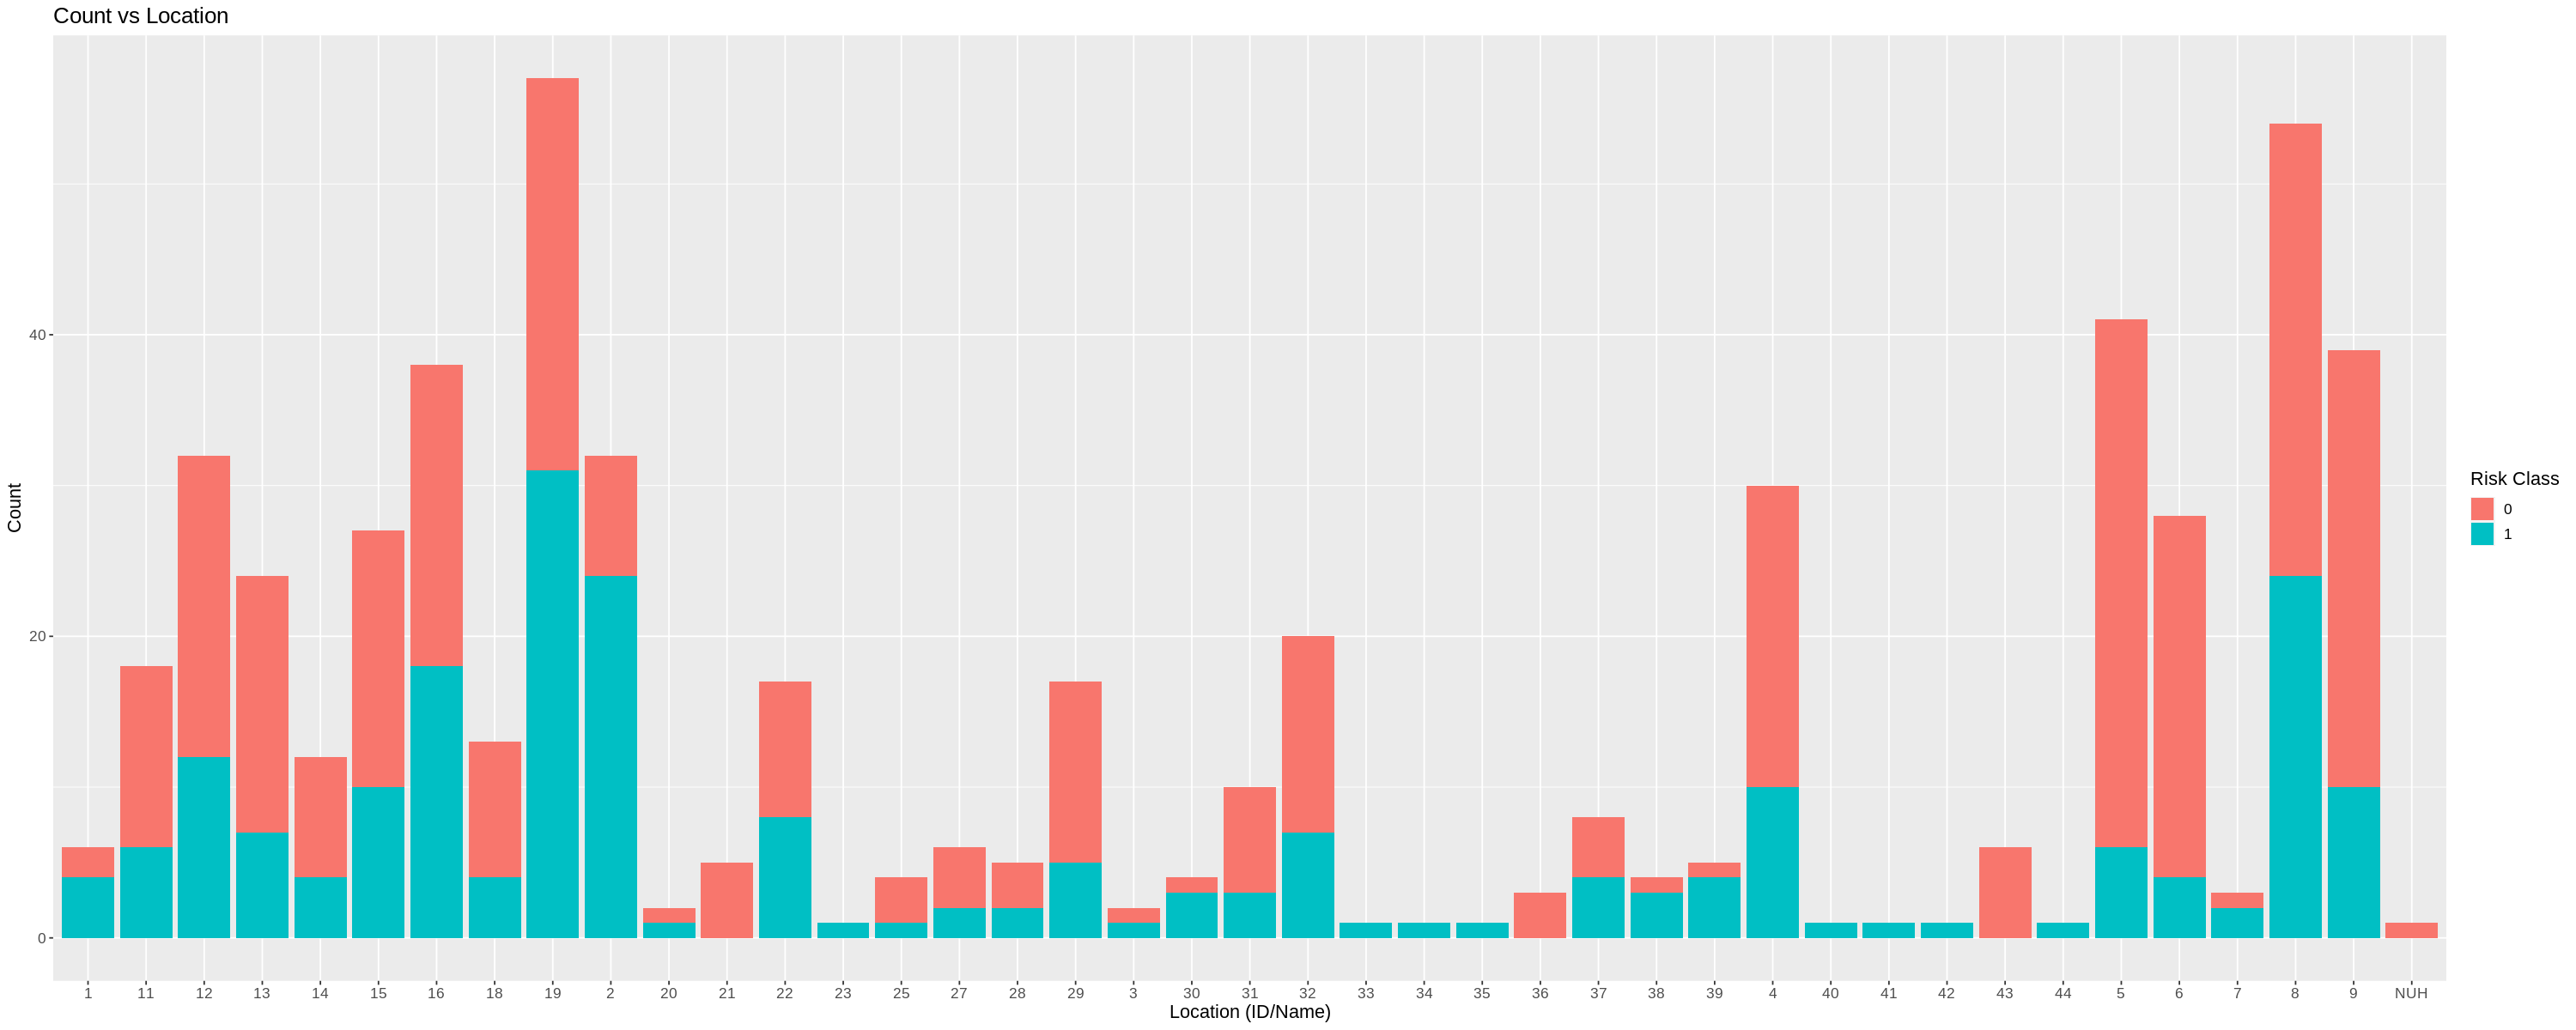

In [11]:
options(repr.plot.width = 25, repr.plot.height = 10) 
location_plot = audit_data_training |> 
    ggplot(aes(x=LOCATION_ID, fill=RISK)) +
        geom_bar() +
        labs(x="Location (ID/Name)", y="Count", fill="Risk Class", title="Count vs Location") +
        theme(text = element_text(size = 13))
location_plot

There is an imbalance of examples for each location, some locations have very few data. No obvious pattern. By intuition location of the firm should not effect the risk. We will drop the location column.

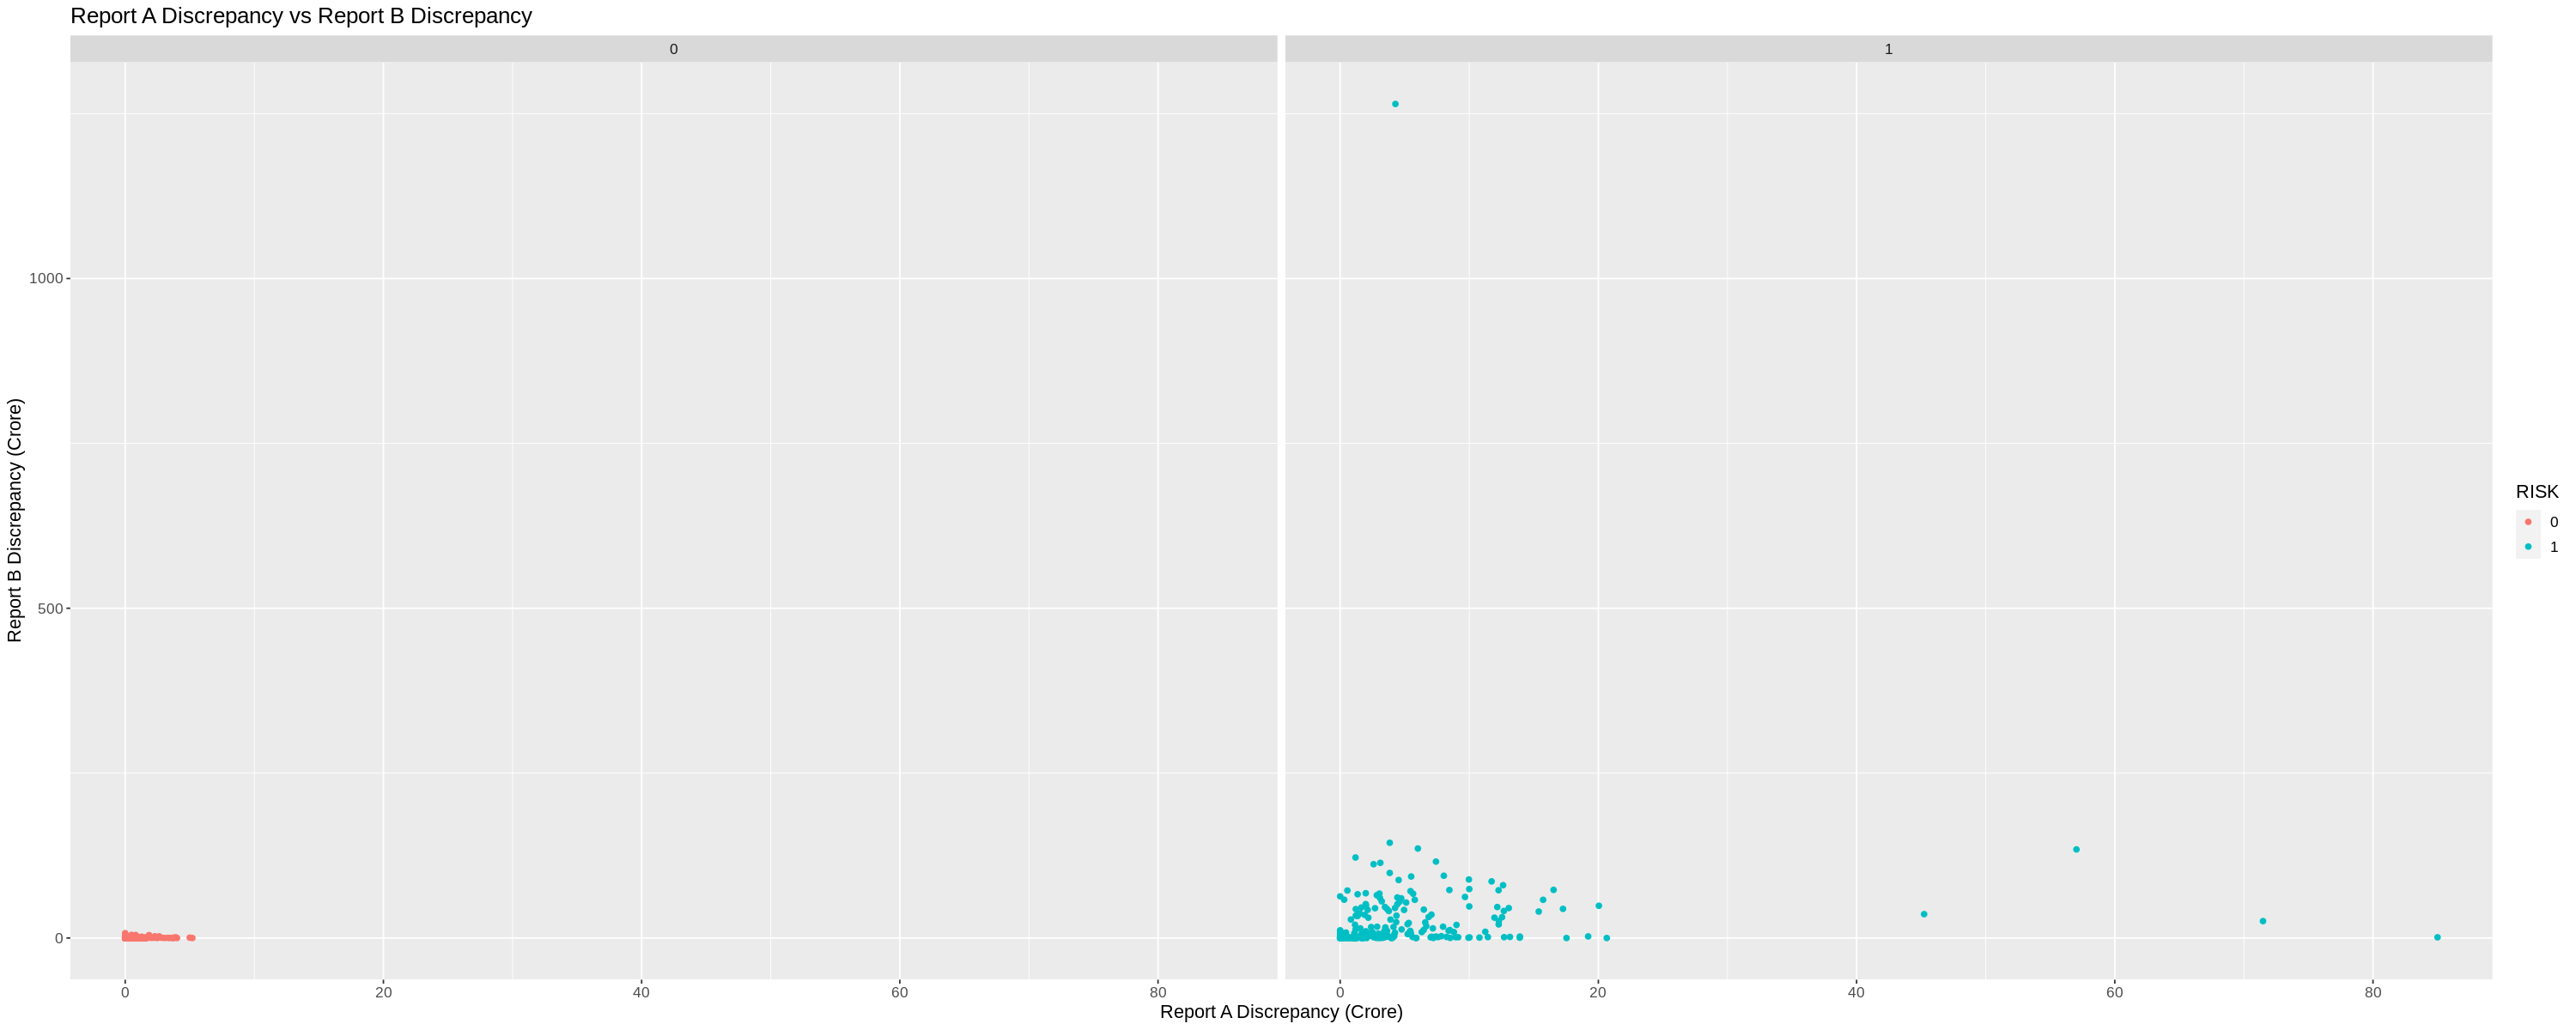

In [12]:
pab_plot = audit_data_training |>
    ggplot(aes(x=PARA_A, y=PARA_B, color=RISK)) +
        geom_point() +
        facet_grid(cols=vars(RISK)) +
        labs(x="Report A Discrepancy (Crore)", y="Report B Discrepancy (Crore)", fill="Risk Class", title="Report A Discrepancy vs Report B Discrepancy") +
        theme(text = element_text(size = 13))
pab_plot

It seems like firms with high discrepancy in A or B are likely to be classified as fraud. However, there are also firms with low discrepancies that are classified as fraud as well. There are some fraud firms who have abnormally high discrepancies. Let's visualize the total discrepancy and see if it is similar.

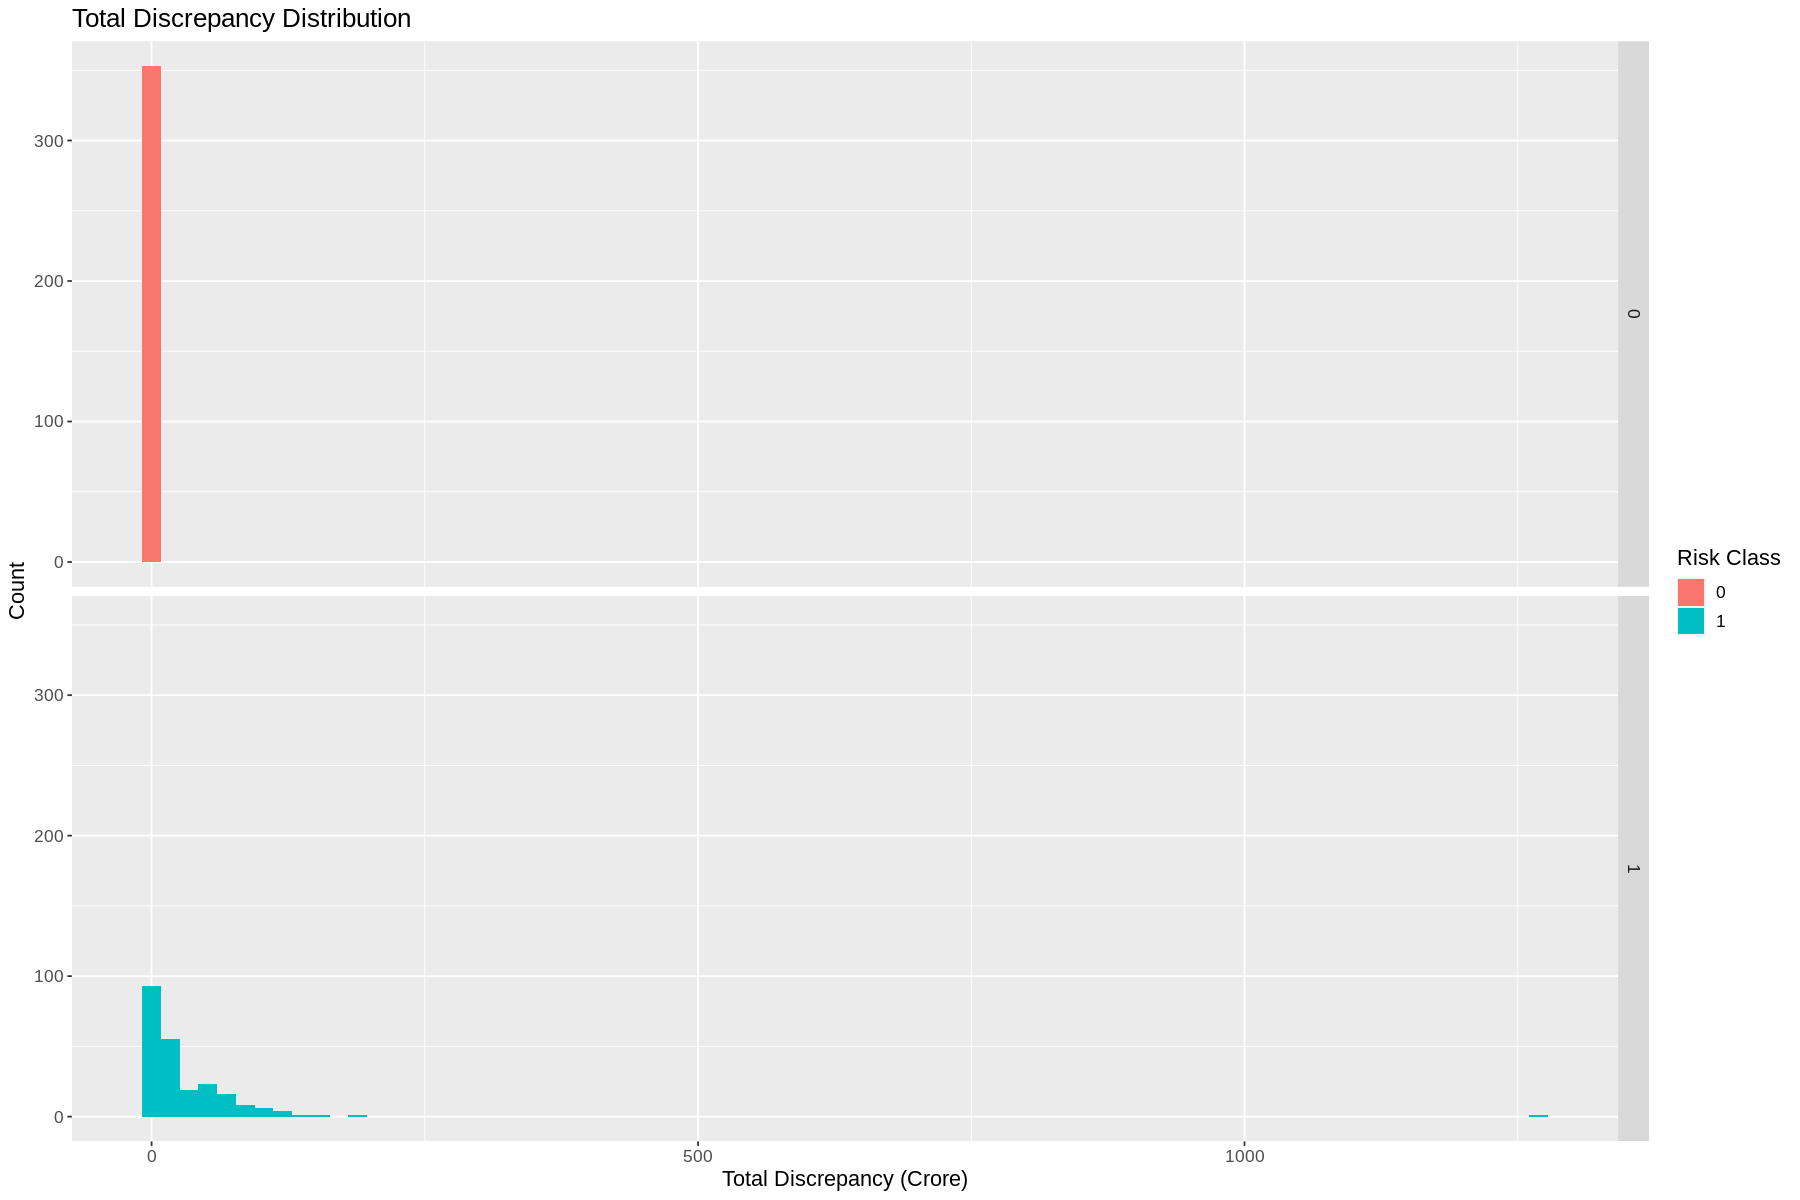

In [13]:
options(repr.plot.width = 15, repr.plot.height = 10) 
total_disc_plot = audit_data_training |>
    ggplot(aes(x=TOTAL, fill=RISK)) +
        geom_histogram(bins=75) +
        facet_grid(rows = vars(RISK)) +
        labs(x="Total Discrepancy (Crore)", y="Count", fill="Risk Class", title="Total Discrepancy Distribution") +
        theme(text = element_text(size = 13))
total_disc_plot

Firms with lower total discrepancy are more likely to be not fraud. What about money value and numbers (historical discrepancy score)?

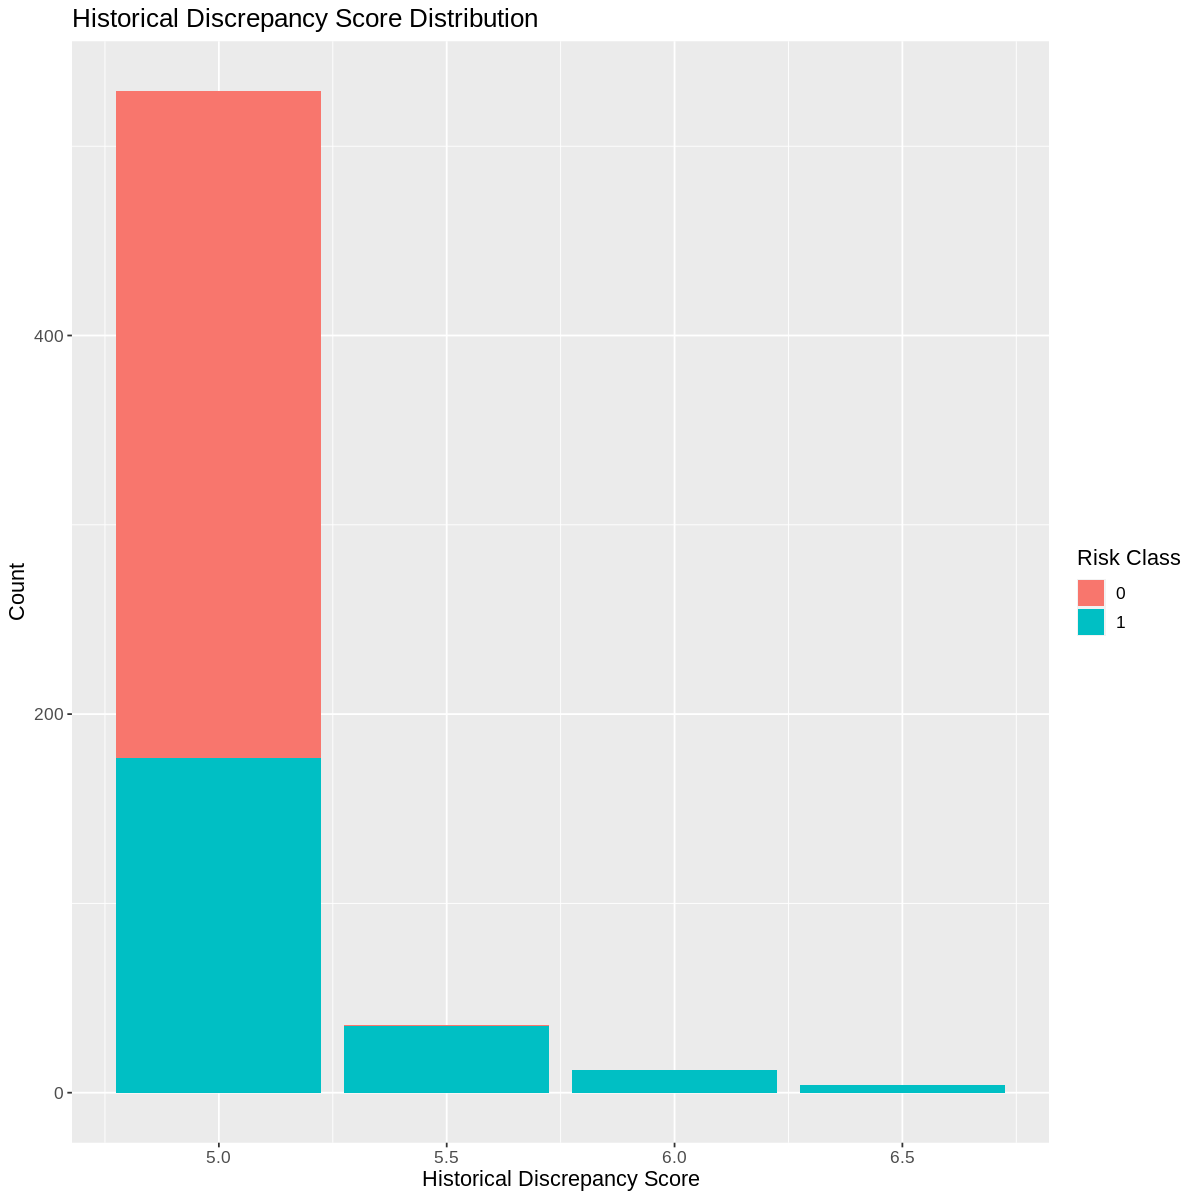

In [14]:
options(repr.plot.width = 10, repr.plot.height = 10) 
numbers_plot = audit_data_training |>
        ggplot(aes(x=NUMBERS, fill=RISK)) +
        geom_bar() +
        labs(x="Historical Discrepancy Score", y="Count", fill="Risk Class", title="Historical Discrepancy Score Distribution") +
        theme(text = element_text(size = 13))
numbers_plot

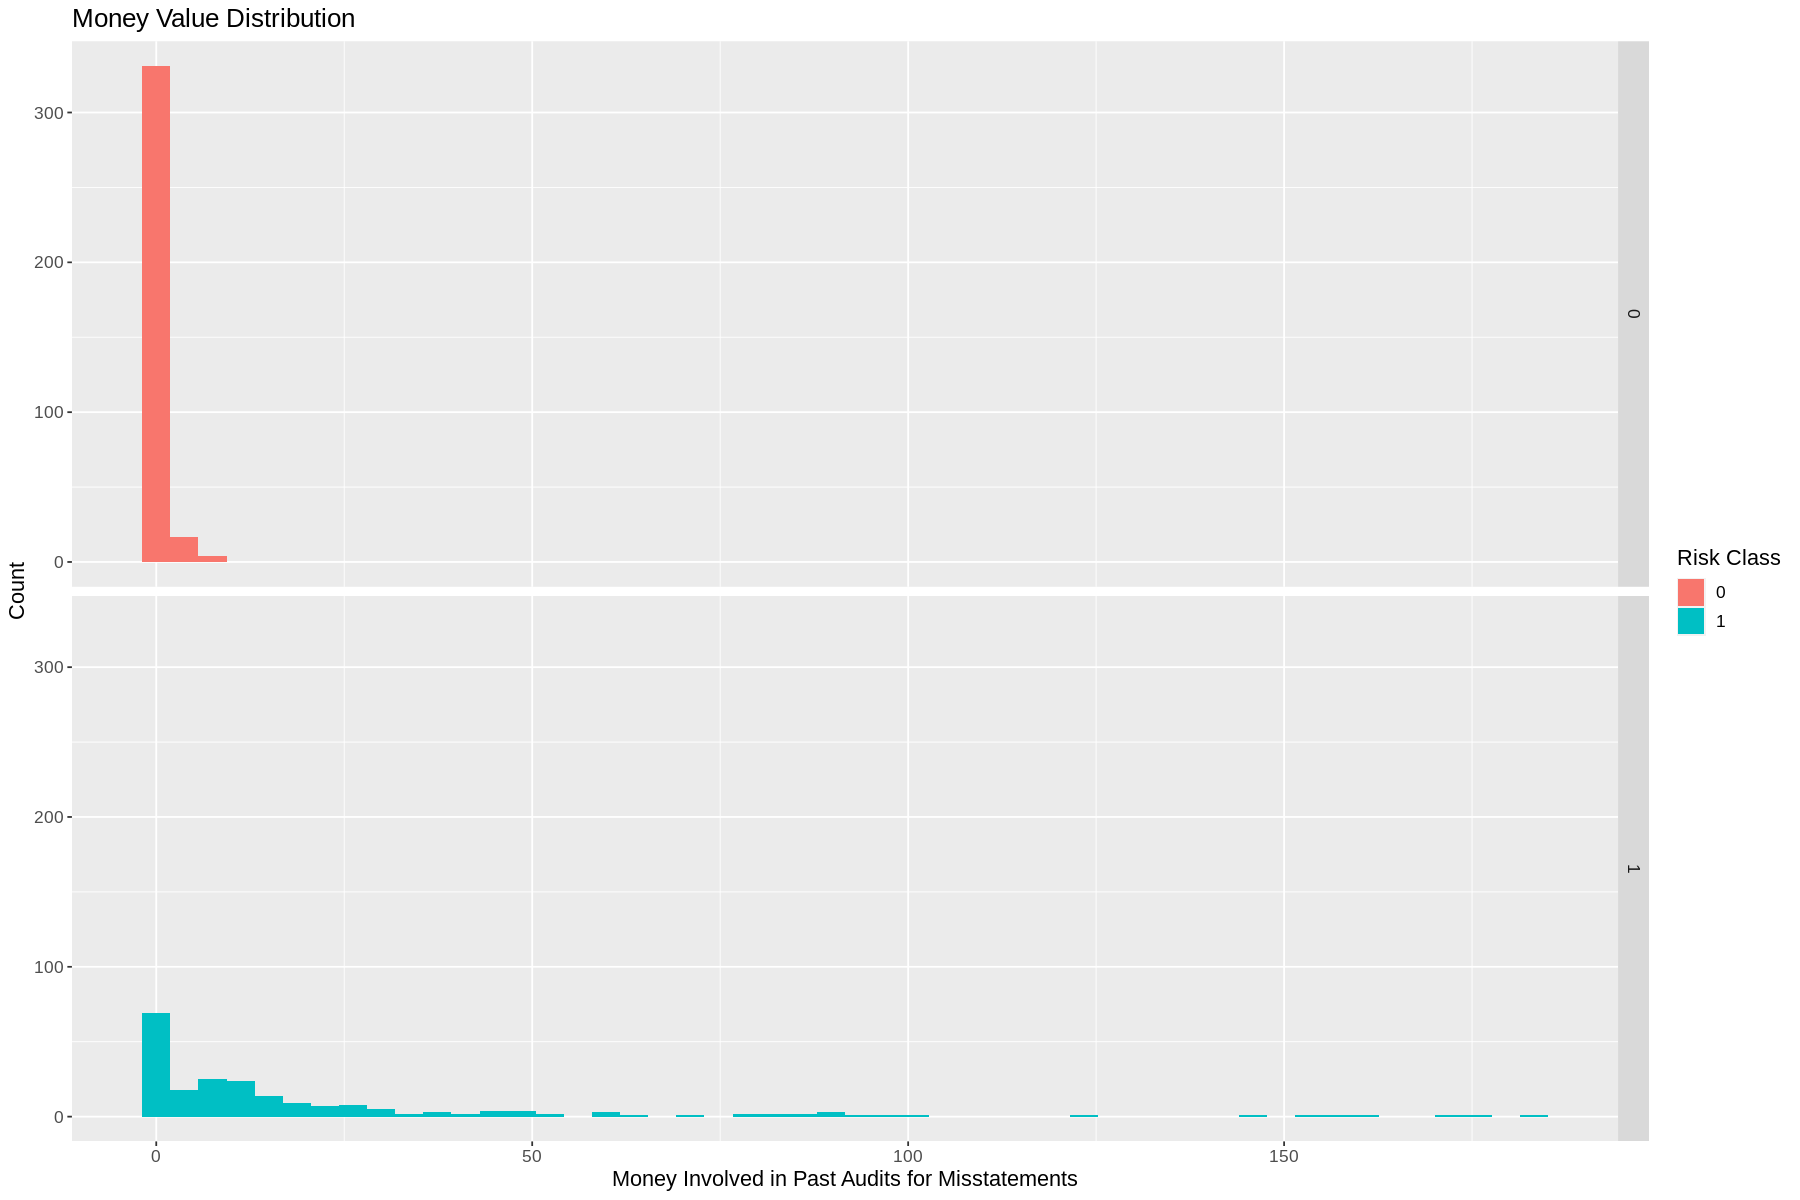

In [15]:
options(repr.plot.width = 15, repr.plot.height = 10) 
money_value_plot = audit_data_training |>
    filter(MONEY_VALUE <= 200) |>
    ggplot(aes(x=MONEY_VALUE, fill=RISK)) +
        geom_histogram(bins=50) +
        facet_grid(rows = vars(RISK)) +
        labs(x="Money Involved in Past Audits for Misstatements", y="Count", fill="Risk Class", title="Money Value Distribution") +
        theme(text = element_text(size = 13))

money_value_plot

Firms with high historical discrepancy score are likely to be fraud. Firm that had a lot of money involved in past audits for misstatements are also likely to be fraud.

# Methods

We will start by reading and cleaning the data, selecting the relevant variables for our prediction: SECTOR_SCORE, PARA_A, PARA_B, TOTAL, NUMBERS, MONEY_VALUE. The dataset will then be divided into training and testing set (75% and 25% respectively). Next, we will find the best k value for our k-nearest neighbors model through cross-validation and regression. Once the model is trained with the training set, we will proceed to predict the risk class for the testing set. Accuracy will be assessed by comparing the predictions with the true values using RMSE calculation.

To visualize the results of multiple variables simultaneously, we will use the “ggpair” function to create a scatterplot matrix. It gives a comprehensive overview of pairwise relationships, helping identify patterns and correlations between variables.

# Expected Outcomes And Significance

The classification model is built to identify fraud companies accurately. We expect the model to uncover patterns within the data that can help distinguish fraudulent companies. It could involve identifying specific financial irregularities, deceptive practices, or unusual behavior exhibited by fraudulent companies.

Having the classification model would firstly enhance fraud detection. The model can assist auditors in allocating their resources more effectively and improving overall fraud detection rates. Secondly, investors and financial institutions would easily identify potential fraud companies and minimize their financial losses by using the model. 

This model would potentially lead to the following questions. New enforcement measures, or changes in reporting requirements may be updated to adapt to evolving fraud schemes. In addition, the identification of fraud companies may prompt further investigation into the root causes and factors that contribute to fraudulent behavior.
